In [1]:
from unidec_modules.ChromEng2 import *
import plate_map2 as pm2
from dataclasses import dataclass
import pandas as pd
import UniChromExtra as uc
import matplotlib.pyplot as plt

In [2]:
spectra_path = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\mzML\\mzML.mzML"
map_path = "unichrom plate map example.xlsx"

In [3]:
eng = ChromEngine()
eng.load_mzml(spectra_path)
eng.config.chrom_peak_width = 0.05
eng.get_chrom_peaks(min = 1) # INSERT PLOT HERE


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Opening HDF5 File: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.hdf5
Reading mzML: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML.gz
Error getting TIC in mzML; trying to make it...
Imported Data. Constructing TIC
Done
1070 2
Noise Level: 0.03357343719702872 Window: 0.05
Bad Peak [0.419567   0.30422294] 0.23768299999999998 [0.419567, 0.65725]
Bad Peak [0.602767   0.24142904] 0.24183299999999996 [0.419567, 0.6614]
0.702967 0.14128400000000008
0.790233 0.16205000000000003
1.0312 0.13711000000000007
1.95747 0.1411800000000003
2.88835 0.13712999999999997
Bad Peak [3.76958    0.03455761] 0.8769500000000003 [3.7197, 4.59665

([array([0.702967  , 0.13838679]),
  array([0.790233  , 0.09750636]),
  array([1.0312    , 0.74873995]),
  array([1.95747   , 0.88543616]),
  array([2.88835, 1.     ])],
 array([[0.686333, 0.827617],
        [0.682183, 0.844233],
        [1.00212 , 1.13923 ],
        [1.9284  , 2.06958 ],
        [2.85927 , 2.9964  ]]))

Getting scans: [98, 131]
Length merge axis: 28915
Getting scans: [321, 355]
Length merge axis: 30293
Getting scans: [545, 578]
Length merge axis: 31336


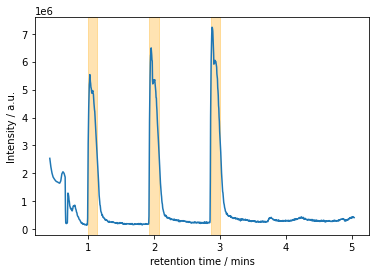

In [4]:
# eng.config.sw_scan_offset = 0 # ??? defaults to 10

eng.add_chrom_peaks2() # stores data from selected peaks ready for metaunidec processing
uc.plot_tic(eng, peak_windows = True)

In [5]:
eng.config.subtype = 2 # background subtraction - subtract curved
eng.config.subbuff = 100 # background subtraction amount(subtract curved) 0 = 0ff, 100 = good amount when on
eng.config.datanorm = 0 # turn off data normalisation

# -- Deconvolution
eng.config.numit = 100 # number of iterations

# mass range (default = 5000.0 to 500000.0 Da)
eng.config.massub = 15000 # upper 
eng.config.masslb = 11000 # lower

eng.config.massbins = 0.1 # sample mass every 0.1 Da

# FWHM 
# eng.get_auto_peak_width()
eng.config.mzsig = 0 

# charge range
eng.config.startz = 1
eng.config.endz = 30

# smoothing 
eng.config.zzsig = 1 # charge smooth width (smooth charge state distributions)
eng.config.psig = 1 # smooth nearby points (point smooth width, some = 1)
eng.config.beta = 0 # suppress artifacts (beta, some = 50)

eng.config.psfun = 0 # Peak shape function (gaussian, lorentzian, split G/L)

# -- Peak Selection and plotting
eng.config.peaknorm = 0 # Normalise peaks (0 = off)
eng.config.datanorm = 0
eng.config.peakwindow = 10 # peak window / Da
eng.config.exnorm = 0 # extract normalisation
eng.config.peakthresh = 0.05
# eng.config.nativeub = 10
# eng.config.nativelb = -10
eng.data.export_hdf5()

In [6]:
eng.process_data()
eng.run_unidec()
eng.pick_peaks() 
eng = uc.integrate_all(eng)

Execution Time: 0.09273600000000037
Execution Time: 3.1822923000000003
Execution Time: 0.17324069999999736
Peak info saved to: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\UniDec_Figures_and_Files\mzML_extracts.txt


In [7]:
# PLATE MAP PROCESSING STARTS HERE
rmap, pmap = pm2.read_in_long(map_path)
eng = pm2.update_vars(eng, pmap, skip_empty = True)
print(rmap)
print(pmap)

        Reaction  Species  Concentration Units     Mass Reagent_Type Sequence
0  17-05-21-CTB1      CTB           10.0    uM  13321.0           SM      NaN
1  17-05-21-CTB1  GVYQSRL           10.0    uM  13184.0           SM  GVYQSRL
2  17-05-21-CTB1     HC7D           10.0    uM  13595.0            C      NaN
3  17-05-21-CTB1   CTB-GV            NaN    uM  13627.0            P      NaN
     Type       Reaction Time  Valid
A1   Test  17-05-21-CTB1    0   True
A2   Test  17-05-21-CTB1   30   True
A3   Test  17-05-21-CTB1   60   True
B1  empty            NaN  NaN   True
B2  empty            NaN  NaN   True
B3  empty            NaN  NaN   True


In [8]:
class Species:
    def __init__(self, dictionary, name, peak = None):
        self.__dict__.update(dictionary)
        self.__name__ = name
        self.peak = peak
        
    
    def __repr__(self):
        keys = [key for key, val in self.__dict__.items()]
        vals = [val for key, val in self.__dict__.items()]
        return self.__name__+ "("+", ".join("{} = {}".format(*t) for t in zip(keys, vals))+")"        

In [9]:
class Time:
    def __init__(self, time, species, coord = None, name = 'Time'):
        self.species = species # list of species in each time point
        self.time = time
        self.coord = coord
        self.__name__= name
        self.spectra = None
        self.thresh = 1
    
    def __repr__(self):
        species_str = "species = (" + ", ".join(s.__name__ for s in self.species)+")"
        if self.spectra == None:
            return self.__name__+ "(time = {}, coord = {}, ".format(self.time, self.coord) + species_str + ")" 
        else:
            return self.__name__+ "(time = {}, coord = {}, spectra = {}, ".format(self.time, self.coord, self.spectra)+ species_str + ")" 
        
    def extract_masses(self):
        self.theory_masses = np.array([sp.Mass for sp in self.species])
        self.species_name = np.array([sp.__name__ for sp in self.species], dtype = str)
        self.data_masses= np.array([p.mass for p in self.spectra.pks.peaks])
        self.pks = np.array([p for p in self.spectra.pks.peaks])
        
    def match_masses(self, thresh = None):
        pass
#         if thresh != None:
#             self.thresh = thresh
#         x, y = np.meshgrid(self.data_masses, self.theory_masses)
#         diff = abs(x - y)
#         diff[diff>self.thresh] = np.nan
#         try:
#             mins = np.nanargmin(diff, axis = 0)
#             self.peaks = self.theory_masses[mins]
#         except:
#             mins = [np.nanargmin(i) for i in diff if np.isnan(i).all() == False]
#             self.peaks = self.theory_masses[mins]

In [10]:
reactions = uc.process(rmap, pmap, eng = eng)

In [11]:
for rkey, rval in reactions.items():
    for t in rval:
        print(t.species)

[<CTB(Reaction = 17-05-21-CTB1, Species = CTB, Concentration = 10.0, Units = uM, Mass = 13321.0, Reagent_Type = SM, Sequence = nan, name = CTB, peak = None, rmap = None, pmap = None, integral = [], Time = ['0' '30' '60'], wells = ['A1' 'A2' 'A3'])>, <CTB-GV(Reaction = 17-05-21-CTB1, Species = CTB-GV, Concentration = nan, Units = uM, Mass = 13627.0, Reagent_Type = P, Sequence = nan, name = CTB-GV, peak = None, rmap = None, pmap = None, integral = [], Time = ['0' '30' '60'], wells = ['A1' 'A2' 'A3'])>, <GVYQSRL(Reaction = 17-05-21-CTB1, Species = GVYQSRL, Concentration = 10.0, Units = uM, Mass = 13184.0, Reagent_Type = SM, Sequence = GVYQSRL, name = GVYQSRL, peak = None, rmap = None, pmap = None, integral = [], Time = ['0' '30' '60'], wells = ['A1' 'A2' 'A3'])>, <HC7D(Reaction = 17-05-21-CTB1, Species = HC7D, Concentration = 10.0, Units = uM, Mass = 13595.0, Reagent_Type = C, Sequence = nan, name = HC7D, peak = None, rmap = None, pmap = None, integral = [], Time = ['0' '30' '60'], wells 

In [12]:
# toplot = None
# for rkey, rval in reactions.items():
#     time = [(t.time) for t in rval]
#     spectra = [t.spectra for t in rval]
#     if toplot == None:
#         # get y vals for each species
#         allspecies = [t.species for t in rval]
        
#     names = []
#     peaks = []
#     for specieslist in allspecies:
#         names.append(np.array([s.name for s in specieslist]))
#         peaks.append(np.array([s.peak.integral[0] for s in specieslist]))
        
    
        
#     names = np.array(names)
#     peaks = np.array(peaks)
    
    
#     plt.plot(time, peaks, marker = 'x')
# peaks

In [13]:

# integrals = [[i[0] for i in s.integrals]for s in spectra]
# integrals

In [14]:
def integrate_all(eng, int_range = None):
    """Creates new spectra attribute and stores areas for each peak there. (eventually put this in UniChrom)"""
    spectra = eng.data.spectra
    
    if int_range == None:
        lb, ub = -eng.config.peakwindow, eng.config.peakwindow
    elif type(int_range) == float:
        lb, ub = int_range[0], int_range[1]
    else:
        lb, ub = -int_range, int_range
        
    for s in spectra:
        peak_ints = []

        for p in s.pks.peaks:
                p.integralrange = [p.mass+lb, p.mass+ub]
                ints = (ud.integrate(s.massdat, p.integralrange[0], p.integralrange[1]))
                p.integral = ints
                peak_ints.append((ints))
        
        s.integrals = peak_ints
    return eng

In [15]:
eng = integrate_all(eng)

In [16]:
for s in eng.data.spectra:
    for p in s.pks.peaks:
        print(p.integral[0])

1219283.8
1154638.2
2394619.5
11643148.0
2706878.0
927751.6
1196650.0
1171638.2
2955347.0
14578023.0
3285878.0
1359808.6
1345707.9
3389886.2
16745840.0
3731566.0


In [17]:
for rkey, rval in reactions.items():
    integrals = []
    names = []
    time = []
    for t in rval:
        t.peak_names = []
        t.integrals = []
        time.append(t.time)
        tm, dm = np.meshgrid(t.theory_masses, t.data_masses)
        diff = abs(tm - dm)
        diff[diff>10] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = t.data_masses[i]
                t.species[minimum].peak = t.pks[i]
                t.species[minimum].integral = t.species[minimum].peak.integral[0]
                t.peak_names.append(t.species[minimum].name)
                t.integrals.append(t.species[minimum].peak.integral[0])
                
                print(t.time, t.species[minimum].name, t.species[minimum].integral)
                for s in t.species:
                    if s.name == t.species[minimum].name:
                        print('yes')
                        s = t.species[minimum]
print("-------------------------------")
for rkey, rval in reactions.items():
    for t in rval:
        for s in t.species:
            print(t.time, s.name, s.integral)

0 GVYQSRL 1154638.2
yes
0 CTB 2394619.5
yes
0 HC7D 11643148.0
yes
0 CTB-GV 2706878.0
yes
30 GVYQSRL 1171638.2
yes
30 CTB 2955347.0
yes
30 HC7D 14578023.0
yes
30 CTB-GV 3285878.0
yes
60 GVYQSRL 1345707.9
yes
60 CTB 3389886.2
yes
60 HC7D 16745840.0
yes
60 CTB-GV 3731566.0
yes
-------------------------------
0 CTB 2394619.5
0 CTB-GV 2706878.0
0 GVYQSRL 1154638.2
0 HC7D 11643148.0
30 CTB 2955347.0
30 CTB-GV 3285878.0
30 GVYQSRL 1171638.2
30 HC7D 14578023.0
60 CTB 3389886.2
60 CTB-GV 3731566.0
60 GVYQSRL 1345707.9
60 HC7D 16745840.0


['GVYQSRL', 'CTB', 'HC7D', 'CTB-GV']
['GVYQSRL', 'CTB', 'HC7D', 'CTB-GV']
['GVYQSRL', 'CTB', 'HC7D', 'CTB-GV']


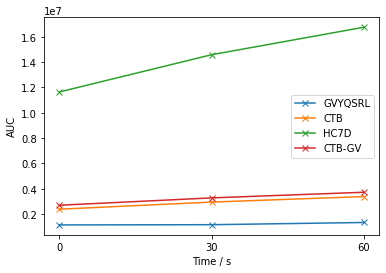

[[1154638.2, 2394619.5, 11643148.0, 2706878.0], [1171638.2, 2955347.0, 14578023.0, 3285878.0], [1345707.9, 3389886.2, 16745840.0, 3731566.0]]
[[ 1154638.2  1171638.2  1345707.9]
 [ 2394619.5  2955347.   3389886.2]
 [11643148.  14578023.  16745840. ]
 [ 2706878.   3285878.   3731566. ]]


In [18]:
for rkey, rval in reactions.items():
    time = []
    ints = []
    for t in rval:
        time.append(t.time)
        ints.append(t.integrals)
        print(t.peak_names)

#     time = np.array(time)
    intsT = np.array(ints).T
    for n, i in enumerate(intsT):
        plt.plot(time, i, marker = 'x', label = t.peak_names[n])
        plt.legend()
        plt.xlabel('Time / s')
        plt.ylabel('AUC')
    plt.show()
print(ints)
print(intsT)

0 2394619.5
0 2706878.0
0 1154638.2
0 11643148.0
30 2955347.0
30 3285878.0
30 1171638.2
30 14578023.0
60 3389886.2
60 3731566.0
60 1345707.9
60 16745840.0


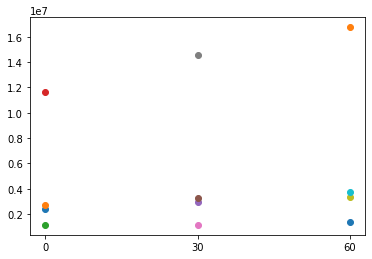

In [19]:
for rkey, rval in reactions.items():
    time = []
    ints = []
    names = []
    for t in rval:
        time.append(t.time)
        ints.append(t.integrals)
        names.append(t.peak_names)
        for sp in t.species:
            print(t.time, sp.peak.integral[0])
            plt.scatter(t.time, sp.integral)
plt.show()

In [20]:
x, y = np.meshgrid(time, integrals)
y

array([], shape=(0, 3), dtype=float64)

In [21]:
for rkey, rval in reactions.items():
    integrals = []
    names = []
    time = []
    dct = {}
    for t in rval:
        tdct = {}
        t.peak_names = []
        t.integrals = []
        time.append(t.time)
        tm, dm = np.meshgrid(t.theory_masses, t.data_masses)
        diff = abs(tm - dm)
        diff[diff>10] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = t.data_masses[i]
                t.species[minimum].peak = t.pks[i]
                t.species[minimum].integral = t.species[minimum].peak.integral[0]
                tdct[t.species[minimum].name] = t.species[minimum].integral
                t.peak_names.append(t.species[minimum].name)
                t.integrals.append(t.species[minimum].peak.integral[0])
                setattr(t.species[minimum], 'integral', t.pks[i].integral[0])
                setattr(t.species[minimum], '__name__', t.species[minimum].name+str(t.time))
#                 for s in t.species:
#                     if s.__name__ == t.species[minimum].__name__:
#                         setattr(s, 'integral', t.species[minimum].integral)
#                         print(s.integral, t.species[minimum].integral)
        dct[t.time] = tdct
        print(t.time)
        for s in t.species:
            print(s.integral)
print("-------------------------------")
for rkey, rval in reactions.items():
    for t in rval:
        print(t.time)
        for s in t.species:
            print(s.integral)
            print(s.name)

0
2394619.5
2706878.0
1154638.2
11643148.0
30
2955347.0
3285878.0
1171638.2
14578023.0
60
3389886.2
3731566.0
1345707.9
16745840.0
-------------------------------
0
2394619.5
CTB
2706878.0
CTB-GV
1154638.2
GVYQSRL
11643148.0
HC7D
30
2955347.0
CTB
3285878.0
CTB-GV
1171638.2
GVYQSRL
14578023.0
HC7D
60
3389886.2
CTB
3731566.0
CTB-GV
1345707.9
GVYQSRL
16745840.0
HC7D


In [22]:
dct

{'0': {'GVYQSRL': 1154638.2,
  'CTB': 2394619.5,
  'HC7D': 11643148.0,
  'CTB-GV': 2706878.0},
 '30': {'GVYQSRL': 1171638.2,
  'CTB': 2955347.0,
  'HC7D': 14578023.0,
  'CTB-GV': 3285878.0},
 '60': {'GVYQSRL': 1345707.9,
  'CTB': 3389886.2,
  'HC7D': 16745840.0,
  'CTB-GV': 3731566.0}}

In [23]:
species_all = []
for rkey, rval in reactions.items():
    integrals = []
    names = []
    time = []
    
    for t in rval:
        species = []
        t.integrals = []
        time.append(t.time)
        tm, dm = np.meshgrid(t.theory_masses, t.data_masses)
        print(t.data_masses)
        diff = abs(tm - dm)
        diff[diff>10] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = t.data_masses[i]
                t.species[minimum].peak = t.pks[i]
                t.species[minimum].integralT = t.species[minimum].peak.integral[0]
                species.append(t.species[minimum])
                
#         print(species)
        print(t.time)
        for sp in species:
            print (sp.integral)
        species_all.append(species)
print("-------------------------------")
for rkey, rval in reactions.items():
    for t in rval:
        print(t.time)
        for s in t.species:
            print(s.integralT)

[13047.7 13184.7 13321.7 13595.4 13627.  13659.9]
0
1154638.2
2394619.5
11643148.0
2706878.0
[13047.101 13184.301 13321.5   13595.601 13627.801]
30
1171638.2
2955347.0
14578023.0
3285878.0
[13046.7 13184.7 13321.6 13595.6 13627.3]
60
1345707.9
3389886.2
16745840.0
3731566.0
-------------------------------
0
2394619.5
2706878.0
1154638.2
11643148.0
30
2955347.0
3285878.0
1171638.2
14578023.0
60
3389886.2
3731566.0
1345707.9
16745840.0


In [24]:
for sp in species_all:
    print(sp)
    for s in sp:
        print(s.integral)

[<GVYQSRL(Reaction = 17-05-21-CTB1, Species = GVYQSRL, Concentration = 10.0, Units = uM, Mass = 13184.0, Reagent_Type = SM, Sequence = GVYQSRL, name = GVYQSRL, peak = <unidec_modules.peakstructure.Peak object at 0x00000210F9F4A1C0>, rmap = None, pmap = None, integral = 1154638.25, Time = ['0' '30' '60'], wells = ['A1' 'A2' 'A3'], __name__ = GVYQSRL0, integralT = 1154638.25)>, <CTB(Reaction = 17-05-21-CTB1, Species = CTB, Concentration = 10.0, Units = uM, Mass = 13321.0, Reagent_Type = SM, Sequence = nan, name = CTB, peak = <unidec_modules.peakstructure.Peak object at 0x00000210F9F4A040>, rmap = None, pmap = None, integral = 2394619.5, Time = ['0' '30' '60'], wells = ['A1' 'A2' 'A3'], __name__ = CTB0, integralT = 2394619.5)>, <HC7D(Reaction = 17-05-21-CTB1, Species = HC7D, Concentration = 10.0, Units = uM, Mass = 13595.0, Reagent_Type = C, Sequence = nan, name = HC7D, peak = <unidec_modules.peakstructure.Peak object at 0x00000210F9F4A700>, rmap = None, pmap = None, integral = 11643148.0